In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
# Step 1: Load Data
customers = pd.read_csv("/content/Customers.csv")
transactions = pd.read_csv("/content/Transactions.csv")

In [3]:
# Step 2: Preprocess Data
# Merge datasets to create a unified dataset
merged_data = transactions.merge(customers, on="CustomerID")

# Aggregate transaction data for each customer
customer_features = merged_data.groupby("CustomerID").agg(
    total_spend=("TotalValue", "sum"),
    avg_spend=("TotalValue", "mean"),
    transaction_count=("TransactionID", "count"),
    region=("Region", "first"),
).reset_index()

# Encode categorical feature (Region)
categorical_features = ["region"]
ohe = OneHotEncoder()
categorical_encoded = ohe.fit_transform(customer_features[categorical_features]).toarray()

# Standardize numerical features
numerical_features = ["total_spend", "avg_spend", "transaction_count"]
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(customer_features[numerical_features])

# Combine numerical and encoded categorical features
final_features = np.hstack((numerical_scaled, categorical_encoded))

In [4]:
# Step 3: Apply K-Means Clustering
# Choose the number of clusters (e.g., 3 to 10)
k_range = range(2, 11)
db_scores = []
kmeans_models = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(final_features)
    kmeans_models.append(kmeans)
    db_index = davies_bouldin_score(final_features, clusters)
    db_scores.append(db_index)

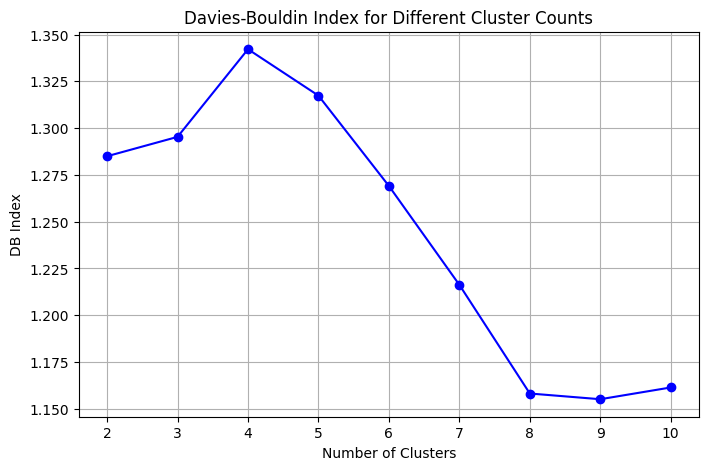

Optimal number of clusters: 9


In [6]:
# Step 4: Evaluate Clustering
# Plot DB Index for different numbers of clusters
plt.figure(figsize=(8, 5))
plt.plot(k_range, db_scores, marker='o', linestyle='-', color='b')
plt.title("Davies-Bouldin Index for Different Cluster Counts")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Select the best model (lowest DB Index)
best_k = k_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {best_k}")

best_model = kmeans_models[np.argmin(db_scores)]
final_clusters = best_model.predict(final_features)

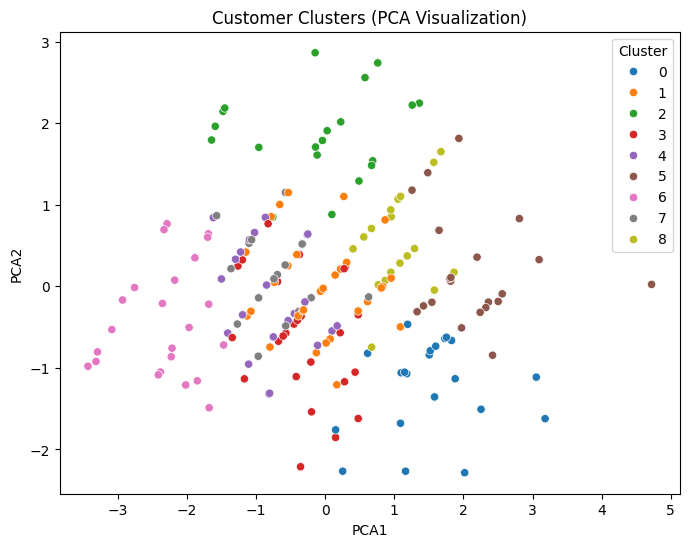

In [7]:
# Step 5: Visualize Clusters
# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(final_features)

# Create a DataFrame for visualization
visualization_df = pd.DataFrame({
    'PCA1': reduced_features[:, 0],
    'PCA2': reduced_features[:, 1],
    'Cluster': final_clusters
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=visualization_df, x="PCA1", y="PCA2", hue="Cluster", palette="tab10")
plt.title("Customer Clusters (PCA Visualization)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()

In [10]:
# Step 6: Save Results and Report
# Add cluster labels to customer features
customer_features["Cluster"] = final_clusters

# Exclude non-numeric columns when calculating the mean
numeric_columns = customer_features.select_dtypes(include=[np.number]).columns
cluster_summary = customer_features.groupby("Cluster")[numeric_columns].mean()


# Print DB Index and cluster summary
print(f"Davies-Bouldin Index for {best_k} clusters: {min(db_scores):.2f}")
print("Cluster Summary:")
print(cluster_summary)

Davies-Bouldin Index for 9 clusters: 1.16
Cluster Summary:
         total_spend    avg_spend  transaction_count  Cluster
Cluster                                                      
0        5256.060000   609.678479           8.666667      0.0
1        3310.881935   678.456115           4.935484      1.0
2        3024.606000  1065.442500           2.800000      2.0
3        2917.816800   561.679530           5.400000      3.0
4        2437.837727   584.245386           4.318182      4.0
5        6513.623810   909.301043           7.238095      5.0
6         801.274348   357.854580           2.304348      6.0
7        2531.303333   641.099722           4.000000      7.0
8        4951.784444   884.614423           5.666667      8.0
